In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.6 MB/s eta 0:00:00


In [66]:
import pennylane as qml
import numpy as nnp
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

**Task 1**

Familiarize yourself with Pennylane. The tutorials in the Pennylane
codebook are a good way to get started. We recommend the codebooks
from the sections “Introduction to Quantum Computing”, “Single-Qubit
Gates” and “Circuits with Many Qubits”,

In [5]:
# Implementing Single qubit gates in pennylane
# X Gate
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit():
    qml.X(wires=0)
    return qml.expval(qml.PauliZ(0))

drawer = qml.draw(circuit)
print(drawer())

0: ──X─┤  <Z>


In [6]:
# Running the circuit using pennlane default backend simulator
circuit()

tensor(-1., requires_grad=True)

In [7]:
# Modifying the measurement to obtain a probability

@qml.qnode(dev)
def circuit():
    qml.X(wires=0)
    return qml.probs(wires=[0])

drawer = qml.draw(circuit)
circuit()

tensor([0., 1.], requires_grad=True)

In [9]:
# Implementing a Hadamard gate
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    return qml.probs(wires=[0])

drawer = qml.draw(circuit)
print(drawer())
print(circuit())

0: ──H─┤  Probs
[0.5 0.5]


In [10]:
# Implementing 2 qubit gate

dev1 = qml.device("default.qubit", wires=2)

@qml.qnode(dev1)
def circuit():
    qml.CNOT(wires=[0,1])
    return qml.probs(wires=[0,1])

drawer = qml.draw(circuit)
print(drawer())
print(circuit())

0: ─╭●─┤ ╭Probs
1: ─╰X─┤ ╰Probs
[1. 0. 0. 0.]


In [11]:
# Implementing Bell State

dev1 = qml.device("default.qubit", wires=2)

@qml.qnode(dev1)
def circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    return qml.probs(wires=[0,1])

drawer = qml.draw(circuit)
print(drawer())
print(circuit())

0: ──H─╭●─┤ ╭Probs
1: ────╰X─┤ ╰Probs
[0.5 0.  0.  0.5]


**Task 2**

To familiarize yourself with the basic
workflow in Quantum Machine Learning, work through the tutorial on
Variational Classifier.

In this task, we will be using the Iris classification dataset to train the QML model.

In [12]:
# Dataset download
!wget https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/iris_classes1and2_scaled.txt

--2024-08-09 18:57:02--  https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/iris_classes1and2_scaled.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12550 (12K) [text/plain]
Saving to: ‘iris_classes1and2_scaled.txt’

iris_classes1and2_s 100%[===================>]  12.26K  --.-KB/s    in 0s      

2024-08-09 18:57:02 (69.7 MB/s) - ‘iris_classes1and2_scaled.txt’ saved [12550/12550]



In [13]:
# The dataset contains 4 features and a class label for each point. It is a binary classification problem
with open('iris_classes1and2_scaled.txt', 'r') as f:
  for i in range(5):
    print(f.readline())

3.999999999999999112e-01 7.500000000000000000e-01 1.999999999999999556e-01 5.000000000000000278e-02 -1.000000000000000000e+00

3.000000000000002665e-01 5.000000000000000000e-01 1.999999999999999556e-01 5.000000000000000278e-02 -1.000000000000000000e+00

2.000000000000001776e-01 6.000000000000000888e-01 1.500000000000000222e-01 5.000000000000000278e-02 -1.000000000000000000e+00

1.499999999999999112e-01 5.500000000000000444e-01 2.500000000000000000e-01 5.000000000000000278e-02 -1.000000000000000000e+00

3.500000000000000888e-01 8.000000000000000444e-01 1.999999999999999556e-01 5.000000000000000278e-02 -1.000000000000000000e+00



In [15]:
dev = qml.device("default.qubit")
dev

<default.qubit device at 0x7890be66f010>

In [18]:
data = np.loadtxt("/content/iris_classes1and2_scaled.txt")
X = data[:, 0:4]
print(f"First X sample (original)  : {X[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X**2, -1))
X_norm = (X.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

Y = data[:, -1]
print(Y[0])

First X sample (original)  : [0.4  0.75 0.2  0.05]
First X sample (normalized): [0.45732956 0.85749293 0.22866478 0.0571662 ]
-1.0


*Step - 1 State preparation*

We will be using Amplitude embedding approach to map the classical values into the quantum hilbert space. These values are embedded in the amplitude of each states after normalization.

Since in this case, having 4 input features, we can perform amplitude embedding using 2 qubits.

In [24]:
# The way in which we do amplitude embedding is through performing angle embedding.
# We compute the angles which have to be applied to the motten state circuit such that
# it produces the output states which has the probabilites proportional to the classical
# features
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [20]:
# Testing the manual implementation of the amplitude embedding
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)

In [22]:
@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()

In [23]:
state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


In [34]:
# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
features[0]

tensor([ 0.47588225, -0.24497866,  0.24497866, -1.080839  ,  1.080839  ], requires_grad=False)

*Step 2 - Ansatz preparation*

In this simple case, we will be using the Basic entangler ansatz which has the parameterized Ry gate for each qubit and a linear connection of CNOT between the pair of qubits.

In [25]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

*Step 3 - Quantum Circuit formulation*

So we prepare the quantum circuit consisting of 4 modules.


1.   Initial state
2.   State prepration
3.   Ansatz
4.   Measurement


We set all 0's as the initial state in this example but there are other initializatio starategies as well. Next, we use the amplitude embedding approach to prepare quantum states from the classical data followed by an basic entangler ansatz. Finally, we perform measurement over Z axis (compute expectation) and readout the classification results.



In [26]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [27]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

*Step 4 - Cost function*

Since, we are performing classication, the square loss function can be used to estimate the average loss for a batch of inputs.

In [28]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [29]:
def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

In [30]:
# We create a function to estimate the accuracy of the model for classification
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [35]:
# Splitting the inputs points for train and test set. We uses 75% for train and 25% for test set.
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

*Step 5 - Setting Random initial weights and biases*

We can prepare the initial set of weights are bias such that its more directed and closer to the global minimum. In this case, we are using a random normal distribution to create the initial set of weights and all 0s for biases.

In [37]:
np.random.seed(0)
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)
print(weights_init, bias_init)

[[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]]

 [[ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]]

 [[ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]

 [[ 0.02269755 -0.01454366  0.00045759]
  [-0.00187184  0.01532779  0.01469359]]

 [[ 0.00154947  0.00378163 -0.00887786]
  [-0.01980796 -0.00347912  0.00156349]]] 0.0


*Step 6 - Optimization*

In [38]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

In [39]:
# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 2.8650255 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:     4 | Cost: 2.8806242 | Acc train: 0.0400000 | Acc validation: 0.0000000
Iter:     6 | Cost: 2.7590485 | Acc train: 0.2266667 | Acc validation: 0.3200000
Iter:     8 | Cost: 2.3538574 | Acc train: 0.4800000 | Acc validation: 0.4400000
Iter:    10 | Cost: 1.5779734 | Acc train: 0.5200000 | Acc validation: 0.4400000
Iter:    12 | Cost: 0.6364346 | Acc train: 0.6266667 | Acc validation: 0.5600000
Iter:    14 | Cost: 0.1456419 | Acc train: 1.0000000 | Acc validation: 1.0000000
Iter:    16 | Cost: 0.1008715 | Acc train: 0.9866667 | Acc validation: 1.0000000
Iter:    18 | Cost: 0.2189263 | Acc train: 0.9866667 | Acc validation: 1.0000000
Iter:    20 | Cost: 0.2764345 | Acc train: 0.9733333 | Acc validation: 0.9600000
Iter:    22 | Cost: 0.2204083 | Acc train: 0.9866667 | Acc validation: 1.0000000
Iter:    24 | Cost: 0.1290415 | Acc train: 0.9866667 | Acc validation: 1.0000000
Iter:    26 | Cost: 0.079979

We can see that model is well trained and able to produce an 100% classifcation accuracy on the test set.

**Task 3**

Consider a more sophisticated model using
an interesting real-world dataset (here the MNIST dataset), Quanvolutional
Neural Networks.

The Quanvolutional neural networks function similarly as like the convolutional layers in a classical CNN model. Instead of applying classical convolutional operation from the window of pixels, we apply a quantum circuit to it.

Here, we will be using the MNIST dataset - a compressed version to perform the classificatio between 0 and 1.

In [47]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "./"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [48]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [49]:
dev = qml.device("default.qubit", wires=4)
dev

<default.qubit device (wires=4) at 0x7890cb76b100>

*Step - 1 - State preparation*

The classical pixel data is converted to quantum hilbert space using Angle embedding rotated along Y axis of the Bloch sphere.

*Step - 2 - Ansatz*

We will be using a Random ansatz cicuit in this case. The circuit contains various rotation gates which are parameterized and some two qubit entanglers.

In [50]:
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

*Step 3 - Quanvolution*

We take the window of pixels and move through the image from the dataset and perform the quanvolution operating by passing the window of pixel to this quantum circuit. This inturn gathers various image features and have a smaller size compared to the input image.

In [51]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [52]:
# Performing the quanvolution preprocessing
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


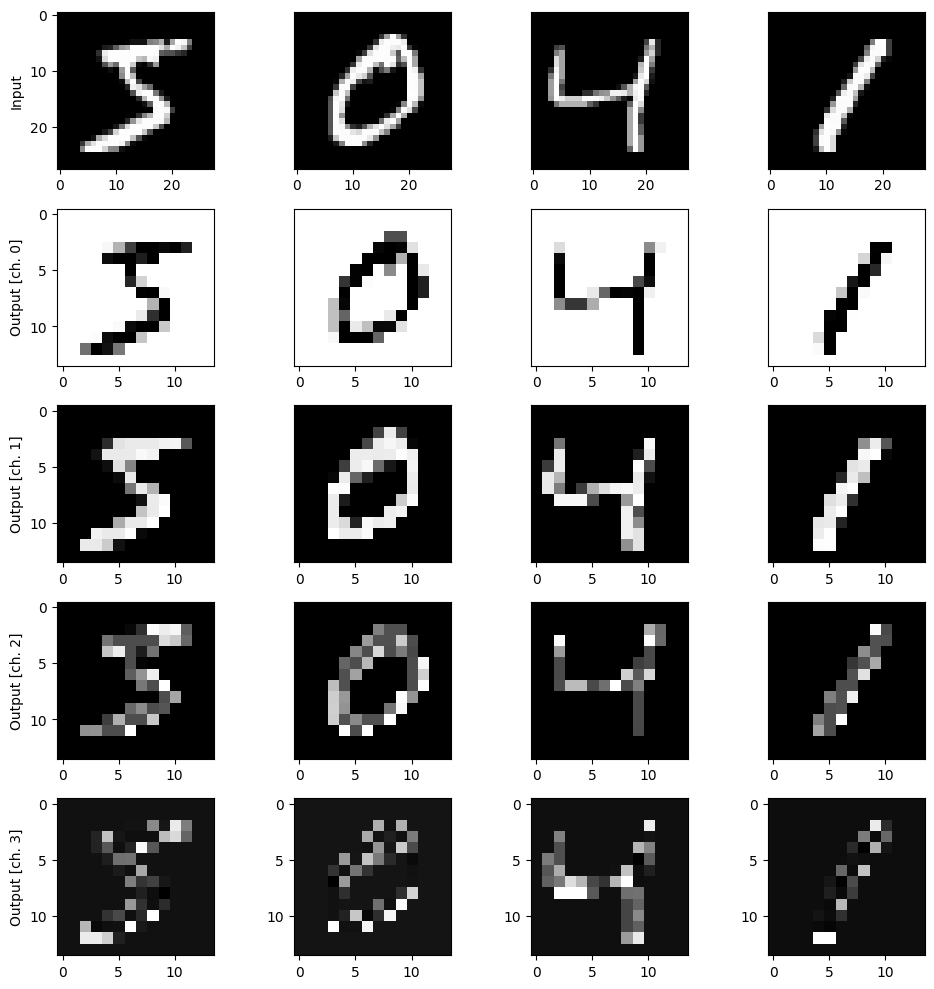

In [53]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

The quanvolution is performed on each input image and we have set of 4 features extracted from each of them. We can use these features as input to the classical model to train on them.

In [54]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [55]:
# Training

q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 110ms/step - accuracy: 0.1600 - loss: 2.6443 - val_accuracy: 0.2333 - val_loss: 2.0093
Epoch 2/30
13/13 - 0s - 28ms/step - accuracy: 0.4200 - loss: 1.8511 - val_accuracy: 0.5333 - val_loss: 1.8507
Epoch 3/30
13/13 - 0s - 5ms/step - accuracy: 0.6000 - loss: 1.5367 - val_accuracy: 0.5333 - val_loss: 1.7086
Epoch 4/30
13/13 - 0s - 5ms/step - accuracy: 0.7000 - loss: 1.2409 - val_accuracy: 0.5667 - val_loss: 1.5602
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.8400 - loss: 1.0189 - val_accuracy: 0.6333 - val_loss: 1.4663
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.9400 - loss: 0.8448 - val_accuracy: 0.6667 - val_loss: 1.3958
Epoch 7/30
13/13 - 0s - 11ms/step - accuracy: 0.9800 - loss: 0.7072 - val_accuracy: 0.6667 - val_loss: 1.3333
Epoch 8/30
13/13 - 0s - 6ms/step - accuracy: 0.9800 - loss: 0.5966 - val_accuracy: 0.7000 - val_loss: 1.2810
Epoch 9/30
13/13 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.5082 - val_accuracy: 0.7000 - val_loss: 1.2396
Epoch 10/30
13

<ipython-input-56-2d4cec98f16d>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


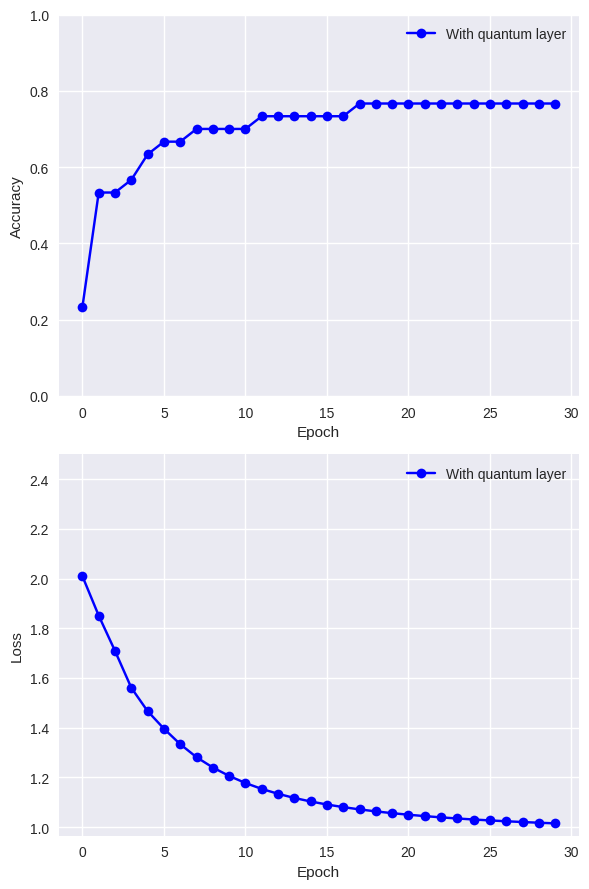

In [56]:
# Plotting the results


plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

**Task 4**

The goal of this subtask is to develop your own
model and use it to learn the sine function on the interval [0, 2π]. Discretize
the interval with a suitable number of points (of your choice) and use the
values of the sine function at these discretization points as labels.
Implement a Quantum Machine Learning model which reproduces the
values of the sine function.

Step 10, Cost: 0.3904
Step 20, Cost: 0.3498
Step 30, Cost: 0.3185
Step 40, Cost: 0.2966
Step 50, Cost: 0.2830
Step 60, Cost: 0.2753
Step 70, Cost: 0.2712
Step 80, Cost: 0.2693
Step 90, Cost: 0.2683
Step 100, Cost: 0.2678
Training complete!
Final cost: 0.2678


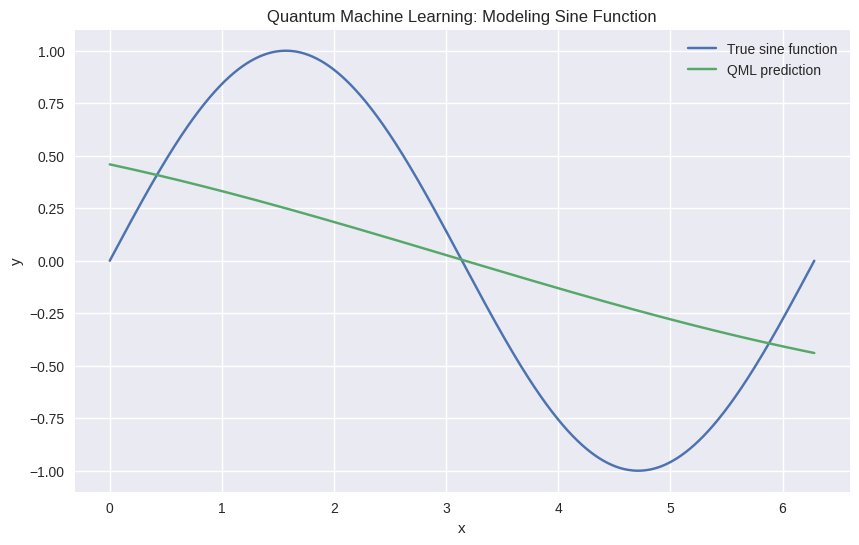

In [325]:
import pennylane as qml
from pennylane import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Define the number of qubits and layers
n_qubits = 4
n_layers = 2

# Create a quantum device
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # State preparation
    for i in range(n_qubits):
        qml.RX(inputs[i], wires=i)

    # Layered Ansatz
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.RX(weights[layer][i][0], wires=i)
            qml.RY(weights[layer][i][1], wires=i)
            qml.RZ(weights[layer][i][2], wires=i)

        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # MEasurement
    return qml.expval(qml.PauliZ(0))

# Cost - Squarred loss
def cost(weights, X, y):
    predictions = [quantum_circuit(x, weights) for x in X]
    return np.mean((np.array(predictions) - y) ** 2)

# Sine data
X = np.linspace(0, 2 * np.pi, 1000)
y = np.sin(X)

# Normalize
X_normalized = (X - np.min(X)) / (np.max(X) - np.min(X))
X_encoded = np.array([X_normalized] * n_qubits).T

shape = (n_layers, n_qubits, 3)
weights = np.random.uniform(low=0, high=2 * np.pi, size=shape,requires_grad = True)


opt = qml.AdamOptimizer(stepsize=0.01)

# Optimization - Gradient Free optimizer
steps = 100
for i in range(steps):
    weights = opt.step(lambda w: cost(w, X_encoded, y), weights)

    if (i + 1) % 10 == 0:
        print(f"Step {i + 1}, Cost: {cost(weights, X_encoded, y):.4f}")

predictions = [quantum_circuit(x, weights) for x in X_encoded]


print(f"Final cost: {cost(weights, X_encoded, y):.4f}")


plt.figure(figsize=(10, 6))
plt.plot(X, y, label="True sine function")
plt.plot(X, predictions, label="QML prediction")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Quantum Machine Learning: Modeling Sine Function")
plt.show()

**Task 5**

We change the data set from the sine function
to real-word data-set from the industry. Download the following data-set
from kaggle: data. You can find more information about the data set in the
following paper.
Implement a Quantum Machine Learning model to detect a defective
production part. The implementation includes the preprocessing of the
data, the implementation of a model and the visualization of the results. You
can use one of the models above. Further, you can also use only a subset
of the downloaded data. The final deliverable should be a notebook in which
all the necessary steps have been carried out and documented.

**Refer other sections and report in GitHub**